## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

In [3]:
print(df.head())
print(df.info())
print(df.columns)

   uid        asin                                              title  stars  \
0    1  B09B96TG33  Echo Dot (5th generation, 2022 release) | Big ...    4.7   
1    2  B01HTH3C8S  Anker Soundcore mini, Super-Portable Bluetooth...    4.7   
2    3  B09B8YWXDF  Echo Dot (5th generation, 2022 release) | Big ...    4.7   
3    4  B09B8T5VGV  Echo Dot with clock (5th generation, 2022 rele...    4.7   
4    5  B09WX6QD65  Introducing Echo Pop | Full sound compact Wi-F...    4.6   

   reviews  price  isBestSeller  boughtInLastMonth        category  
0    15308  21.99         False                  0  Hi-Fi Speakers  
1    98099  23.99          True                  0  Hi-Fi Speakers  
2    15308  21.99         False                  0  Hi-Fi Speakers  
3     7205  31.99         False                  0  Hi-Fi Speakers  
4     1881  17.99         False                  0  Hi-Fi Speakers  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 col

### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

---

In [5]:
# Crosstab analysis

# Create crosstab
crosstab = pd.crosstab(df['category'], df['isBestSeller'])
print(crosstab)

# Pproportion of best-sellers per category
crosstab['proportion'] = crosstab[True] / (crosstab[True] + crosstab[False])
crosstab_sorted = crosstab.sort_values('proportion', ascending=False)
print("\nTop categories by best-seller proportion:")
print(crosstab_sorted.head(10))

isBestSeller                    False  True 
category                                    
3D Printers                       247      1
3D Printing & Scanning           4065      2
Abrasive & Finishing Products     245      5
Action Cameras                   1696      1
Adapters                          251      3
...                               ...    ...
Wind Instruments                  243      7
Window Treatments                 234      5
Women                           17559    213
Women's Sports & Outdoor Shoes   1939     20
eBook Readers & Accessories       246      0

[296 rows x 2 columns]

Top categories by best-seller proportion:
isBestSeller                    False  True  proportion
category                                               
Grocery                          9008   556    0.058135
Smart Home Security & Lighting     98     6    0.057692
Health & Personal Care           9017   552    0.057686
Mobile Phone Accessories          248    11    0.042471
Power & Hand

In [10]:
# Chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(crosstab)
print(f"\nChi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")


# Cramér's V
n = crosstab.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
print(f"\nCramér's V: {cramers_v:.3f}")


# There is a significant relationship, but the strengh of this relationship is weak


Chi-square statistic: 36684.24
P-value: 0.0000

Cramér's V: 0.087


<Figure size 1200x600 with 0 Axes>

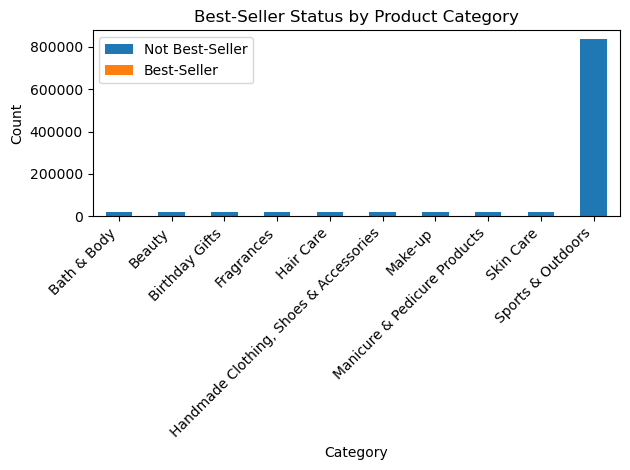

In [12]:
# Best sellers: 10 first

top_categories = df['category'].value_counts().head(10).index
df_top = df[df['category'].isin(top_categories)]

crosstab_top = pd.crosstab(df_top['category'], df_top['isBestSeller'])

plt.figure(figsize=(12, 6))
crosstab_top.plot(kind='bar', stacked=True)
plt.title('Best-Seller Status by Product Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(['Not Best-Seller', 'Best-Seller'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Category "Sports & Outdoors" is not a best seller.

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


In [13]:
# IQR method 


# Calculate IQR for price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: £{lower_bound:.2f}")
print(f"Upper bound: £{upper_bound:.2f}")

# Remove outliers
df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"\nOriginal dataset: {len(df)} products")
print(f"After removing outliers: {len(df_clean)} products")
print(f"Removed: {len(df) - len(df_clean)} products")

Lower bound: £-44.01
Upper bound: £99.99

Original dataset: 2443651 products
After removing outliers: 2115963 products
Removed: 327688 products


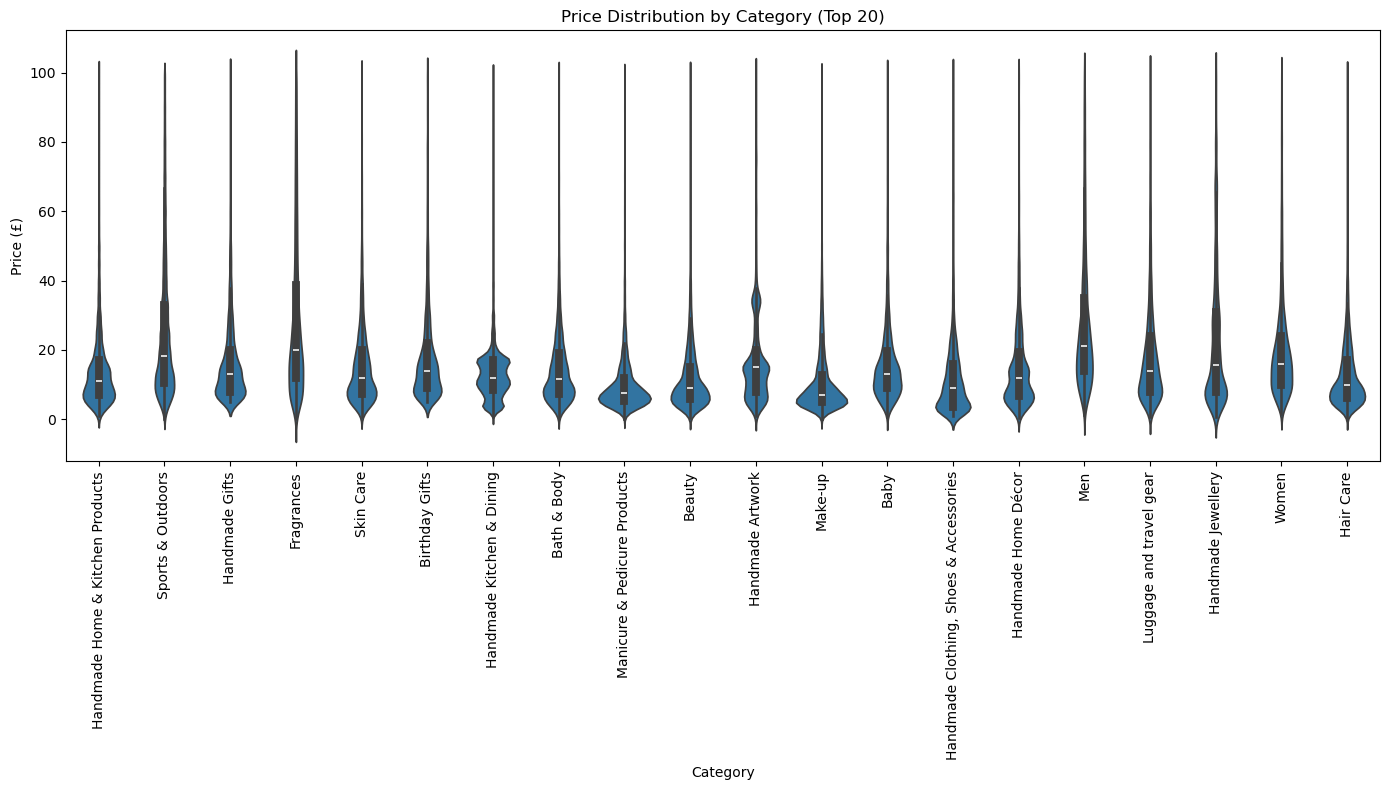

In [14]:
# violin plots (20 categories)


top_20_categories = df_clean['category'].value_counts().head(20).index
df_top20 = df_clean[df_clean['category'].isin(top_20_categories)]

plt.figure(figsize=(14, 8))
sns.violinplot(data=df_top20, x='category', y='price')
plt.title('Price Distribution by Category (Top 20)')
plt.xlabel('Category')
plt.ylabel('Price (£)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


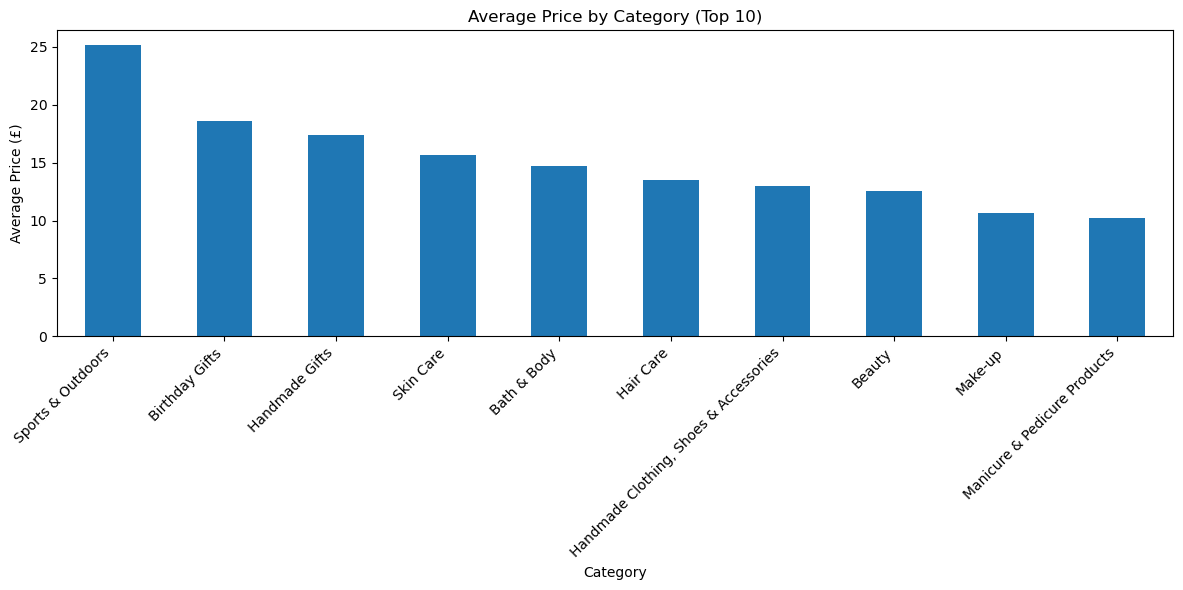

In [15]:
# Bar charts 


top_10_categories = df_clean['category'].value_counts().head(10).index
df_top10 = df_clean[df_clean['category'].isin(top_10_categories)]

# Average price per category
avg_prices = df_top10.groupby('category')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_prices.plot(kind='bar')
plt.title('Average Price by Category (Top 10)')
plt.xlabel('Category')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# The product category who commands the highest average price is sports and outdoors.

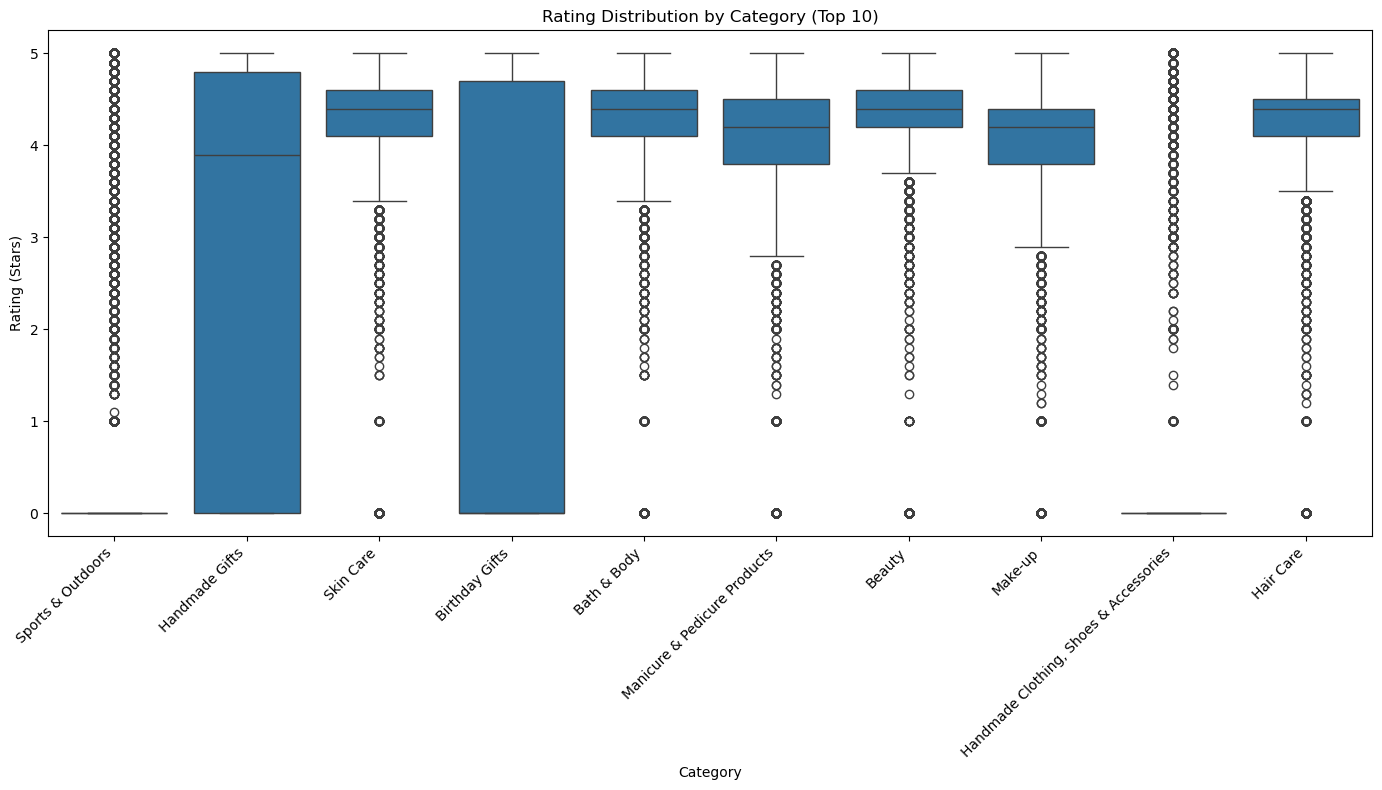

In [16]:
# Box plots

df_top10_rating = df_clean[df_clean['category'].isin(top_10_categories)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_top10_rating, x='category', y='stars')
plt.title('Rating Distribution by Category (Top 10)')
plt.xlabel('Category')
plt.ylabel('Rating (Stars)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# The category who receive the highest median is handmade gifts

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


In [18]:
# Correlation between price and stars

correlation = df_clean['price'].corr(df_clean['stars'])
print(f"Correlation between Price and Stars: {correlation:.3f}")

# Correlation : the rating lower when the price rise.

Correlation between Price and Stars: -0.078


In [ ]:
# Scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(df_clean['stars'], df_clean['price'], alpha=0.1) # alpha : transparency
plt.title('Price vs Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Price (£)')
plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap (all numerical variables)

numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap - Numerical Variables')
plt.tight_layout()
plt.show()


In [ ]:
# QQ plot (check if price is normally distributed

plt.figure(figsize=(8, 6))
stats.probplot(df_clean['price'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Price Distribution')
plt.tight_layout()
plt.show()


**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?